In [84]:
from tensorflow.keras.datasets import reuters
import pandas as pd
import numpy as np
import time

import os
from dotenv import load_dotenv

In [85]:
path = "./data/"

In [86]:
ls data

1.crypto_apps_reviews_raw.csv         co.mona.android.csv
2.crypto_app_reviews_tagged.csv       com.binance.dev.csv
2.crypto_category.txt                 com.bybit.app.csv
3.tagged_reviews_sample.csv           crypt_app_llm_tagged.csv
4.tagged_reviews_sample_verified.csv  crypto_app_llm_tagged.csv


In [87]:
df_r = pd.read_csv(path+"/4.tagged_reviews_sample_verified.csv")

## Train test split

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
df_r.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app,gemini_llm_topic,correct,human_labeled_topic,cause
0,9cab4f6e-8203-4a69-8774-0304f0eab6a7,Radek Raczkowski,https://play-lh.googleusercontent.com/a-/ALV-U...,This app weights 460 MB! Old review: Stop forc...,1,0,3.204.10,2025-03-08 12:42:40,"Hello, Radek. We strive to improve our platfor...",2025-03-08 13:35:03,3.204.10,co.mona.android,Usability/UI/UX,1,NaN,NaN
1,cedc9258-9d32-438c-98b4-8d63bad10031,Derek DeLucia,https://play-lh.googleusercontent.com/a/ACg8oc...,Super glitchy app which is awfully sus for hav...,2,0,3.201.20,2024-12-21 11:36:07,Hello Dereck. We will be happy to look into th...,2024-12-10 16:24:15,3.201.20,co.mona.android,Usability/UI/UX,1,NaN,NaN


In [90]:
X = df_r
y = df_r.gemini_llm_topic

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)


X_train = X_train.sample(X_train.shape[0]*20, replace=True)
#split text and labels
train_sentences = X_train.content.to_numpy()
train_labels = X_train.gemini_llm_topic.to_numpy()
test_sentences = X_test.gemini_llm_topic.to_numpy()
test_labels = y_test.to_numpy()

In [93]:
X_train.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app,gemini_llm_topic,correct,human_labeled_topic,cause
196,8f0c4f2d-9752-4c78-a388-320194f7be45,Amy Dowell,https://play-lh.googleusercontent.com/a/ACg8oc...,I can add my venmo card but can't buy crypto E...,2,0,3.201.10,2024-12-20 9:07:50,Hello Amy! We invite you to contact us via liv...,2024-12-20 9:26:04,3.201.10,co.mona.android,Account Management,1,NaN,NaN
264,272b0fc2-98a8-4b4e-aece-56dd6fcfdcf9,Zabihullah Jan,https://play-lh.googleusercontent.com/a-/ALV-U...,good,2,0,2.94.6,2025-01-26 12:37:48,Hi there! We are pleased that we met your expe...,2025-01-26 12:48:17,2.94.6,com.binance.dev,Generic feedback,1,NaN,NaN


## Tokenize

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

In [15]:
from collections import Counter

In [16]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

In [17]:
#!pip install scikit-learn

In [21]:
counter = counter_word(df_r.content)

In [95]:
counter_lower = counter_word(df_r.content.str.lower())

In [96]:
counter.most_common(10)

[('the', 283),
 ('to', 282),
 ('I', 190),
 ('and', 185),
 ('a', 154),
 ('is', 131),
 ('my', 122),
 ('it', 112),
 ('you', 111),
 ('app', 99)]

In [97]:
counter_lower.most_common(10)

[('the', 323),
 ('to', 286),
 ('i', 220),
 ('and', 202),
 ('a', 159),
 ('is', 135),
 ('my', 129),
 ('it', 129),
 ('you', 122),
 ('app', 109)]

In [24]:
num_unique_words = len(counter)
print(num_unique_words)

2508


In [25]:
#vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) #fit only to trainin

In [28]:
#vectorize the labels
le = LabelEncoder()
le.fit(df_r.gemini_llm_topic.to_numpy()) #fit only to trainin

LabelEncoder()

In [29]:
le.inverse_transform([0])

array(['Account Management'], dtype=object)

In [30]:
#each word has a unique index
word_index = tokenizer.word_index

In [31]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [32]:
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

In [35]:
print("Example sequence 1:")
print(train_sentences[10:11])
print(train_sequences[10:11])
print("Example sequence 2:")
print(train_sentences[20:21])
print(train_sequences[20:21])

Example sequence 1:
['very easy very fast love the app']
[[56, 98, 56, 746, 114, 1, 9]]
Example sequence 2:
['Due to not listed pi network']
[[329, 2, 14, 217, 59, 132]]


As seen above, sequences can have different lengths since the sentences may contain a distinct number of words. We need all sequences to be of the same length, and for this we will use padding.

In [36]:
#Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#max number of words in a sequence
max_length = 255

train_padded = pad_sequences(train_sequences, maxlen= max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, test_padded.shape

((4780, 255), (60, 255))

In [37]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [38]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [39]:
decoded_text = decode(train_sequences[10])

In [40]:
decoded_text

'very easy very fast love the app'

## Train model

In [46]:
num_classes = df_r["gemini_llm_topic"].nunique()

In [47]:
num_classes

12

In [50]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     51
Generic feedback                    50
Reliability/Stability               39
Account Management                  38
Customer Support                    36
Transaction Fees/Speed              31
Features/Functionality              25
Verification/KYC/AML Processes      16
Security                             5
Educational Resources/Onboarding     4
Wallet Security/Integration          3
Privacy                              1
Name: count, dtype: int64

In [48]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [49]:
model = keras.Sequential([
layers.Dense(num_classes*20, 
             #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes, activation="softmax")
])

## Compile the model

In [61]:
model.compile(optimizer="rmsprop",
loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

In [62]:
len(train_padded)

4780

In [63]:
#validation set
x_val = train_padded[:100]
partial_x_train = train_padded[100:]
y_val = y_train[:100]
partial_y_train = y_train[100:]

In [64]:
history = model.fit(train_padded,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.7)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9631 - loss: 0.5877 - val_accuracy: 0.9818 - val_loss: 0.4760
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9629 - loss: 0.5903 - val_accuracy: 0.9848 - val_loss: 0.4652
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9493 - loss: 0.5801 - val_accuracy: 0.9812 - val_loss: 0.4610
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9529 - loss: 0.5997 - val_accuracy: 0.9812 - val_loss: 0.4601
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9617 - loss: 0.5564 - val_accuracy: 0.9812 - val_loss: 0.4565
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9627 - loss: 0.5558 - val_accuracy: 0.9812 - val_loss: 0.4520
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9623 - loss: 0.5267 - val_accuracy: 0.9812 - val_loss: 0.4515
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9591 - loss: 0.5188 - val_accuracy: 0.9812 - val_loss: 0.4490


In [65]:
#!pip install matplotlib

In [66]:
import matplotlib.pyplot as plt

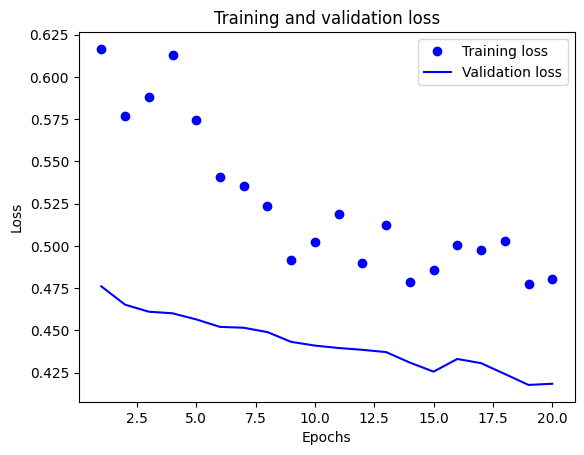

In [67]:
#plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [68]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [71]:
train_metric = 'accuracy'
val_metric = 'val_accuracy'

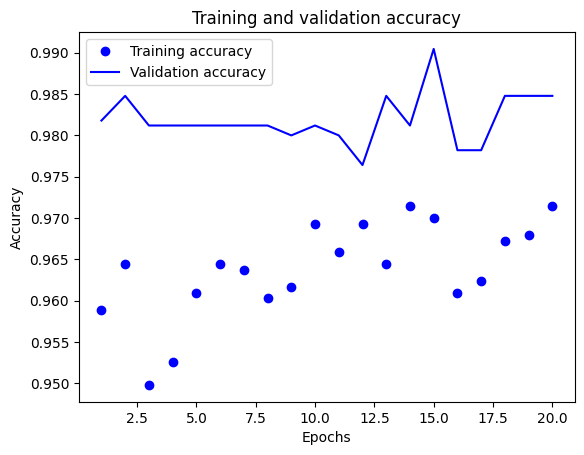

In [72]:
#plotting the training and validation accuracy
plt.clf()
acc = history.history[train_metric]
val_acc = history.history[val_metric]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [73]:
model.evaluate(test_padded, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1299 - loss: 9.8194


[10.599756240844727, 0.11666666716337204]

In [74]:
y_test

array([ 4,  4,  1,  1,  0,  4, 11,  0,  8,  0,  0,  0,  0,  6,  1,  6,  0,
        6,  0,  1,  6,  6,  9,  3,  8,  4,  4,  8,  1,  3,  3,  6,  9,  6,
        0,  9,  6,  6, 10,  6,  8,  3,  9, 10,  6,  3,  3,  4,  3,  6,  1,
        1,  8,  3,  4,  6,  3,  9,  0,  9])

In [75]:
predictions = model.predict(test_padded)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [76]:
pred_list = []
for p in predictions:
   pred_list.append(p.argmax())

In [77]:
from sklearn.metrics import f1_score

In [78]:
f1_score(y_test, pred_list, average='micro')

0.11666666666666667

In [79]:
qa_df = pd.DataFrame({"text":X_test.content.to_numpy(), 
              "true_value":le.inverse_transform(y_test), 
              "predicted_value": le.inverse_transform(pred_list)})

In [80]:
for row in qa_df.to_dict(orient="records"):
    if row["predicted_value"]!= "generic feedback":
        print(row["text"])
        print("True value:",row["true_value"])
        print("Predicted value:", row["predicted_value"])
        print("***********************")

1 star 🌟 till I've tried and tested the app myself
True value: Generic feedback
Predicted value: Generic feedback
***********************
good
True value: Generic feedback
Predicted value: Generic feedback
***********************
This is the worst user friendly app. They claim there is no phone number to actually speak to someone. The people on the chat don't understand most issues, so you constantly have to repeat yourself. This app is incredibly bad with the lack of customer support especially.
True value: Customer Support
Predicted value: Generic feedback
***********************
the bybt app is cool, but you guys need 2 upgrade on something, why wud a seller hold a buyer's transaction witout sending money, the buyer wud marked the transaction as sucesful without sendn the money, bcus of misunderstanding, that's not professional, cus u guys would @ the end tell the person 2 sort it out with the seller, knowing fully wel is not ethics, you guys shud upgrade knowing wen someone's isn't